<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand-vertical.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.978 · TFM Area 1</p>
<p style="margin: 0; text-align:right;">2023-1 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'informàtica, multimèdia i telecomunicació</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Àlex Franco Granell</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Exploratory analysis of the data

In this Jupyter notebook, I will undertake various preliminary tasks to develop a prediction model, as well as conduct a thorough analysis of the data collected for this research. The dataset utilized originates from participants in experimental speed dating events held between 2002 and 2004. During these events, attendees engaged in four-minute "first dates" with every other participant of the opposite sex. Post each interaction, participants indicated their interest in future meetings and rated their dates on six attributes: Attractiveness, Sincerity, Intelligence, Fun, Ambition, and Shared Interests. Additionally, the dataset includes questionnaire responses obtained at different stages, covering demographics, dating habits, self-perception across key attributes, beliefs about desirable traits in a partner, and lifestyle information.

This extensive dataset offers a comprehensive understanding of participants' experiences and perceptions during the speed dating events, providing valuable insights into the dynamics of initial romantic encounters and the factors influencing participants' assessments of one another. We will use these insights to choose the best features to provide in our training models.

Index of contents:

 1. **Data Preprocessing**: Where most data transformations occur for the final dataset. Has the output of SpeedDating_Original.csv and optionally SpeedDating_clean.csv
 
     1.1. **Alternative data preprocessing for continuous variables**: Has the optional output of SpeedDating_clean_continuous.csv, for a continuous dataset.
     
 2. **Eploratory analysis**: This section analyzes the distributions of the data
 
     2.1. **Type correction**: Saves the data ready to be processed in SpeedDating_processed.csv
     
     2.2. **Post-processed analysis**: If loaded, generates additional analysis from the processed data, such as correlation matrices and variable significance analysis.
     
Below you can choose which execution you want for this notebook. If you are only interested in having the data ready for predictive analysis, run it with OPTIONAL_OUTPUTS = FALSE; it will be faster and less messy.

Furthermore you can also load the post-processing analysis, but keep in mind that it takes a little longer to run and requires more libraries than just the usual processing. If you only want the data for the predictive model you can leave it as POST_PROCESSED_ANALYSIS = False.




In [1]:
# Execution control:
OPTIONAL_OUTPUTS = True
POST_PROCESSED_ANALYSIS = True

## 1. Data preprocessing

In [2]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib

In [3]:
# Loading required libraries
import pandas as pd
import numpy as np
from scipy.io import arff
from io import StringIO
import time
import requests
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load data from url
url = "https://www.openml.org/data/download/13153954/speeddating.arff"

# Make a GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Convert the ARFF content to a pandas DataFrame
    data, meta = arff.loadarff(StringIO(response.text))
    df = pd.DataFrame(data)
    
    # Decode bytes
    df = df.apply(lambda x: x.map(lambda y: y.decode('utf-8') if isinstance(y, bytes) else y))
    
    print(f"Dataframe with {len(df.columns)} columns and {len(df.index)} rows")
else:
    print(f"Error retrieving the dataset. Status code: {response.status_code}")
    

# Save for future proofing
df.to_csv("./Data/SpeedDating_Original.csv", index=False)
time.sleep(1)

Dataframe with 123 columns and 8378 rows


In [4]:
for c in df.columns:
    print(c)

has_null
wave
gender
age
age_o
d_age
d_d_age
race
race_o
samerace
importance_same_race
importance_same_religion
d_importance_same_race
d_importance_same_religion
field
pref_o_attractive
pref_o_sincere
pref_o_intelligence
pref_o_funny
pref_o_ambitious
pref_o_shared_interests
d_pref_o_attractive
d_pref_o_sincere
d_pref_o_intelligence
d_pref_o_funny
d_pref_o_ambitious
d_pref_o_shared_interests
attractive_o
sinsere_o
intelligence_o
funny_o
ambitous_o
shared_interests_o
d_attractive_o
d_sinsere_o
d_intelligence_o
d_funny_o
d_ambitous_o
d_shared_interests_o
attractive_important
sincere_important
intellicence_important
funny_important
ambtition_important
shared_interests_important
d_attractive_important
d_sincere_important
d_intellicence_important
d_funny_important
d_ambtition_important
d_shared_interests_important
attractive
sincere
intelligence
funny
ambition
d_attractive
d_sincere
d_intelligence
d_funny
d_ambition
attractive_partner
sincere_partner
intelligence_partner
funny_partner
ambiti

In [5]:
# Searching for Nan

pna = df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]

print(f"Column:\t\t\t\t  %Nan:\n{pna}")

Column:				  %Nan:
age                               1.133922
age_o                             1.241346
importance_same_race              0.942946
importance_same_religion          0.942946
pref_o_attractive                 1.062306
pref_o_sincere                    1.062306
pref_o_intelligence               1.062306
pref_o_funny                      1.169730
pref_o_ambitious                  1.277154
pref_o_shared_interests           1.539747
attractive_o                      2.530437
sinsere_o                         3.425639
intelligence_o                    3.652423
funny_o                           4.296968
ambitous_o                        8.617809
shared_interests_o               12.843161
attractive_important              0.942946
sincere_important                 0.942946
intellicence_important            0.942946
funny_important                   1.062306
ambtition_important               1.181666
shared_interests_important        1.444259
attractive                        1

As we can see through this run, most of the nulls are in the input data and not in the columns that were discretized for the preceding analysis.

With a superficial exploration of the dataset through external tools I could see that it was assumed that people who generally did not answer or did not have the data for their answer gave little importance to the question.

For example the importance_same_race column has been discretized with nulls converted to [0-1]. In other words, it is assumed that if these people did not answer, or if the data were not available, the person did not attach importance to this question.

Otherwise, it should be noted, as shown below, that some present the record as '?'. This may indicate that many of the unknown discretized responses were known to be of little importance to participants; and that at the same time there was data that they did not know.

I did an initial analysis by cleaning the continuous data and removing the discretized ones. This solution was not bad per se, we could say that it was more conservative, but I finally decided to work with the discretized data because it contains more records.

Cleaning up the continuums I finally realized that the best way to deal with nulls, after cleaning up the unnecessary attributes, was to remove the records because I couldn't make any realistic assumptions about the data in order to infer them. This leaves the dataset with fewer records than that approximation, but with more data certainty.

With the final approximation we have more data for analysis, but it falls under the assumption that previous researchers have consciously discretized the data without introducing erroneous data.

In [6]:
# Remove ? values
print("Original number of ? =", (df == '?').sum().sum(), "\n")
df_na = df.replace('?', np.nan)
print("Final number of ? =", (df_na == '?').sum().sum(), "\n")

# Searching for Nan
pna = df_na[df_na.columns[df_na.isnull().any()]].isnull().sum() * 100 / df.shape[0]

print(f"Column:\t\t\t\t  %Nan:\n{pna}")

Original number of ? = 199 

Final number of ? = 0 

Column:				  %Nan:
age                               1.133922
age_o                             1.241346
race                              0.751969
race_o                            0.871330
importance_same_race              0.942946
importance_same_religion          0.942946
field                             0.751969
pref_o_attractive                 1.062306
pref_o_sincere                    1.062306
pref_o_intelligence               1.062306
pref_o_funny                      1.169730
pref_o_ambitious                  1.277154
pref_o_shared_interests           1.539747
attractive_o                      2.530437
sinsere_o                         3.425639
intelligence_o                    3.652423
funny_o                           4.296968
ambitous_o                        8.617809
shared_interests_o               12.843161
attractive_important              0.942946
sincere_important                 0.942946
intellicence_important   

In [7]:
col_c = ["d_age",
         "importance_same_race",
         "importance_same_religion",
         "pref_o_attractive",
         "pref_o_sincere",
         "pref_o_intelligence",
         "pref_o_funny",
         "pref_o_ambitious",
         "pref_o_shared_interests",
         "attractive_o",
         "sinsere_o",
         "intelligence_o",
         "funny_o",
         "ambitous_o",
         "shared_interests_o",
         "attractive_important",
         "sincere_important",
         "intellicence_important",
         "funny_important",
         "ambtition_important",
         "shared_interests_important",
         "attractive",
         "sincere",
         "intelligence",
         "funny",
         "ambition",
         "attractive_partner",
         "sincere_partner",
         "intelligence_partner",
         "funny_partner",
         "ambition_partner",
         "shared_interests_partner",
         "sports",
         "tvsports",
         "exercise",
         "dining",
         "museums",
         "art",
         "hiking",
         "gaming",
         "clubbing",
         "reading",
         "tv",
         "theater",
         "movies",
         "concerts",
         "music",
         "shopping",
         "yoga",
         "d_interests_correlate",
         "expected_happy_with_sd_people",
         "expected_num_interested_in_me",
         "expected_num_matches",
         "like",
         "guess_prob_liked"]

# Remove continuous variables:
data_d = df_na.drop(columns=col_c)

# Remove remaining nulls (field and met)
data_d = data_d.dropna()

# Solve field column
data_d['field'] = data_d['field'].str.lower()

print("Remaining NA:", data_d.isnull().sum().sum(), "\n")
print("With columns:")
for c in data_d.columns:
    print(c)

Remaining NA: 0 

With columns:
has_null
wave
gender
age
age_o
d_d_age
race
race_o
samerace
d_importance_same_race
d_importance_same_religion
field
d_pref_o_attractive
d_pref_o_sincere
d_pref_o_intelligence
d_pref_o_funny
d_pref_o_ambitious
d_pref_o_shared_interests
d_attractive_o
d_sinsere_o
d_intelligence_o
d_funny_o
d_ambitous_o
d_shared_interests_o
d_attractive_important
d_sincere_important
d_intellicence_important
d_funny_important
d_ambtition_important
d_shared_interests_important
d_attractive
d_sincere
d_intelligence
d_funny
d_ambition
d_attractive_partner
d_sincere_partner
d_intelligence_partner
d_funny_partner
d_ambition_partner
d_shared_interests_partner
d_sports
d_tvsports
d_exercise
d_dining
d_museums
d_art
d_hiking
d_gaming
d_clubbing
d_reading
d_tv
d_theater
d_movies
d_concerts
d_music
d_shopping
d_yoga
interests_correlate
d_expected_happy_with_sd_people
d_expected_num_interested_in_me
d_expected_num_matches
d_like
d_guess_prob_liked
met
decision
decision_o
match


As we can see, there are still many variables here that are directly linked to the previous study, and do not make sense in our prediction modelling. That's why I remove them:

In [8]:
col_c = ["has_null", "wave", "d_expected_happy_with_sd_people", "d_expected_num_interested_in_me",
         "d_expected_num_matches", "d_like", "d_guess_prob_liked", "met", "decision", "decision_o"]

# Remove non-useful variables:
data_d = data_d.drop(columns=col_c)

print(f"Dataframe with {len(data_d.columns)} columns and {len(data_d.index)} rows\n")

for c in data_d.columns:
    print(c," ", data_d[c].unique())

Dataframe with 58 columns and 7802 rows

gender   ['female' 'male']
age   [21. 24. 25. 23. 22. 26. 27. 30. 28. 29. 34. 35. 32. 39. 20. 19. 18. 37.
 33. 36. 31. 42. 38. 55.]
age_o   [27. 22. 23. 24. 25. 30. 28. 21. 26. 29. 39. 32. 34. 35. 18. 20. 19. 37.
 33. 36. 31. 42. 38. 55.]
d_d_age   ['[4-6]' '[0-1]' '[2-3]' '[7-37]']
race   ['Asian/Pacific Islander/Asian-American' 'European/Caucasian-American'
 'Other' 'Latino/Hispanic American' 'Black/African American']
race_o   ['European/Caucasian-American' 'Asian/Pacific Islander/Asian-American'
 'Latino/Hispanic American' 'Other' 'Black/African American']
samerace   ['0' '1']
d_importance_same_race   ['[2-5]' '[6-10]' '[0-1]']
d_importance_same_religion   ['[2-5]' '[0-1]' '[6-10]']
field   ['law' 'economics' 'masters in public administration'
 'masters of social work&education' 'finance' 'business'
 'political science' 'money' 'operations research' 'tc [health ed]'
 'psychology' 'social work' 'speech language pathology'
 'educational psychol

Now we have a clean dataset with every colum stored as a pandas series. The information we can extract is that the data has been discretized following the following criteria:

- Importance of different attributes in a couple (other): [0-15], [16-20], [21-100]
- Rating of the other on the user: [0-5], [6-8], [9-10]
- Importance of different attributes in a couple (user): [0-15], [16-20], [21-100]
- Self-perception of the user: [0-5], [6-8], [9-10]
- Score of the user over the other: [0-5], [6-8], [9-10]
- User interests: [0-5], [6-8], [9-10]

From what you can see in the data, an attempt was made to discretize everything into three sets for better comparison later, I can gather. Regarding the importance of different attributes in a couple, it seems that either little, no or some importance is given to each characteristic.

In terms of self-perception data and scoring, it is as low score, 0-5, moderate score, 6-8, and high score, 9-10.

Ultimately, I consider these discretizations to be correct for the problem presented for several reasons. First because they simplify the interpretation of the data (no need to compare attributes from 56 to 64%), and because the discretizations are really realistic in terms of interpreting personal tastes. You can give little importance to a characteristic, or a lot, but what is certain is that people who rate these characteristics as important to them can move this variable a lot.

Although the data is now correct, as we can see, it is stored in the wrong series. We need to save them with the correct index and values in order to work with the data. We will do this in the next section, for now we will keep the data as it is.

In [9]:
print(data_d['gender'].index)

Index([   0,    1,    2,    3,    4,    5,    6,    8,    9,   10,
       ...
       8368, 8369, 8370, 8371, 8372, 8373, 8374, 8375, 8376, 8377],
      dtype='int64', length=7802)


In [10]:
# Save current dataset:
data = data_d
data.to_csv("./Data/SpeedDating_clean.csv")

### 1.1. Alternative data preprocessing for continuous variables

In [11]:
if OPTIONAL_OUTPUTS == True:
    data = pd.read_csv(r"./Data/SpeedDating_Original.csv")
    
    data = data.replace('?', np.nan)
    
    col_d = ["d_age",
             "d_d_age",
             "d_importance_same_race",
             "d_importance_same_religion",
             "d_pref_o_attractive",
             "d_pref_o_sincere",
             "d_pref_o_intelligence",
             "d_pref_o_funny",
             "d_pref_o_ambitious",
             "d_pref_o_shared_interests",
             "d_attractive_o",
             "d_sinsere_o",
             "d_intelligence_o",
             "d_funny_o",
             "d_ambitous_o",
             "d_shared_interests_o",
             "d_attractive_important",
             "d_sincere_important",
             "d_intellicence_important",
             "d_funny_important",
             "d_ambtition_important",
             "d_shared_interests_important",
             "d_attractive",
             "d_sincere",
             "d_intelligence",
             "d_funny",
             "d_ambition",
             "d_attractive_partner",
             "d_sincere_partner",
             "d_intelligence_partner",
             "d_funny_partner",
             "d_ambition_partner",
             "d_shared_interests_partner",
             "d_sports",
             "d_tvsports",
             "d_exercise",
             "d_dining",
             "d_museums",
             "d_art",
             "d_hiking",
             "d_gaming",
             "d_clubbing",
             "d_reading",
             "d_tv",
             "d_theater",
             "d_movies",
             "d_concerts",
             "d_music",
             "d_shopping",
             "d_yoga",
             "d_interests_correlate",
             "d_expected_happy_with_sd_people",
             "d_expected_num_interested_in_me",
             "d_expected_num_matches",
             "d_like",
             "d_guess_prob_liked"]
    
    # Remove discrete
    data = data.drop(columns=col_d)
    
    col_c = ["has_null", "wave", "expected_happy_with_sd_people", "expected_num_interested_in_me",
             "expected_num_matches", "like", "guess_prob_liked", "met", "decision", "decision_o"]

    # Remove non-useful variables:
    data = data.drop(columns=col_c)
    
    # Remove remaining nulls
    data = data.dropna()
    
    print("Remaining NA:", data.isnull().sum().sum(), "\n")
    print(f"Dataframe with {len(data.columns)} columns and {len(data.index)} rows\n")
    print("With columns:")
    for c in data.columns:
        print(c)
        
    # Note that there are a few more attributes, because age and race are kept from this previous iteration
    data.to_csv("./Data/SpeedDating_clean_continuous.csv")

Remaining NA: 0 

Dataframe with 57 columns and 5790 rows

With columns:
gender
age
age_o
race
race_o
samerace
importance_same_race
importance_same_religion
field
pref_o_attractive
pref_o_sincere
pref_o_intelligence
pref_o_funny
pref_o_ambitious
pref_o_shared_interests
attractive_o
sinsere_o
intelligence_o
funny_o
ambitous_o
shared_interests_o
attractive_important
sincere_important
intellicence_important
funny_important
ambtition_important
shared_interests_important
attractive
sincere
intelligence
funny
ambition
attractive_partner
sincere_partner
intelligence_partner
funny_partner
ambition_partner
shared_interests_partner
sports
tvsports
exercise
dining
museums
art
hiking
gaming
clubbing
reading
tv
theater
movies
concerts
music
shopping
yoga
interests_correlate
match


## 2. Exploratory analysis

First, let's scan the data to see which distributions occur:

In [12]:
data = pd.read_csv("./Data/SpeedDating_clean.csv")
data = data.drop('Unnamed: 0', axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7802 entries, 0 to 7801
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        7802 non-null   object 
 1   age                           7802 non-null   float64
 2   age_o                         7802 non-null   float64
 3   d_d_age                       7802 non-null   object 
 4   race                          7802 non-null   object 
 5   race_o                        7802 non-null   object 
 6   samerace                      7802 non-null   int64  
 7   d_importance_same_race        7802 non-null   object 
 8   d_importance_same_religion    7802 non-null   object 
 9   field                         7802 non-null   object 
 10  d_pref_o_attractive           7802 non-null   object 
 11  d_pref_o_sincere              7802 non-null   object 
 12  d_pref_o_intelligence         7802 non-null   object 
 13  d_p

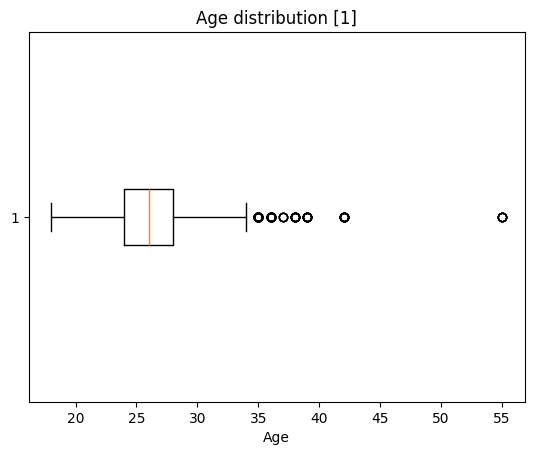

count    7802.000000
mean       26.360933
std         3.573708
min        18.000000
25%        24.000000
50%        26.000000
75%        28.000000
max        55.000000
Name: age, dtype: float64


In [13]:
PLOT_COUNT = 0

PLOT_COUNT += 1
# Create plot Age
plt.boxplot(data["age"], vert=False)
plt.xlabel("Age")
plt.title(f"Age distribution [{PLOT_COUNT}]")

plt.show()
print(data["age"].describe())

Most of the data appears to be between 18 and 28 years old. However, outliers are not a problem because we have the data discretized by age difference

gender
female    3904
male      3898
Name: count, dtype: int64


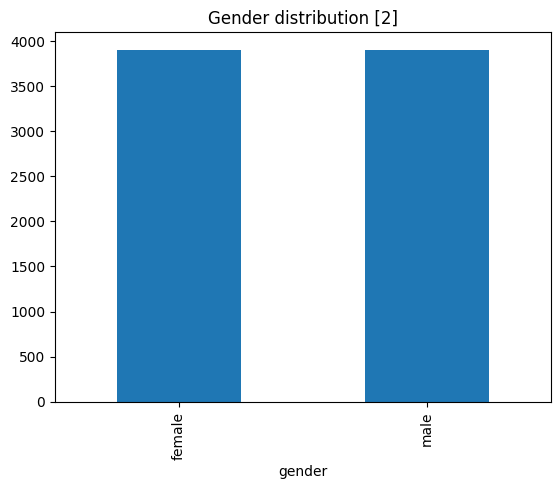

In [14]:
PLOT_COUNT += 1
data["gender"].value_counts().plot(kind="bar", title = f"Gender distribution [{PLOT_COUNT}]")
print(data["gender"].value_counts())

The dataset appears to be fairly balanced in terms of male and female records. Regarding the race records I have to say that I did several tests with the continuous data and the race has very little importance when defining pairwise sorting algorithms.

Although we will not explore this for this reason, both race and whether they are of the same race have been retained in order to provide this in the final algorithm, essentially for business model reasons.

Now we will show the relationship of each variable according to the objective of making a match

match
0    83.196616
1    16.803384
Name: proportion, dtype: float64


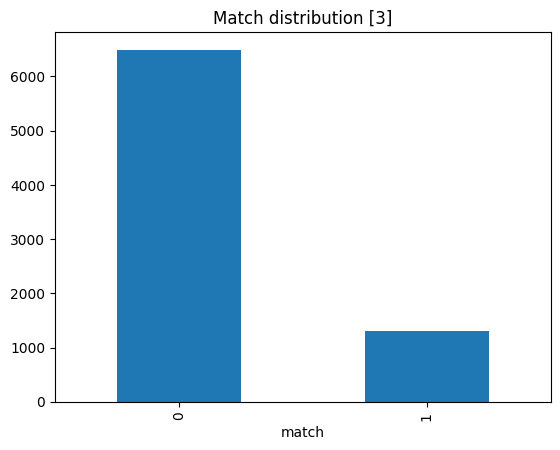

In [15]:
# First we see how our matches are distributed in the dataset
PLOT_COUNT += 1
data["match"].value_counts().plot(kind="bar", title = f"Match distribution [{PLOT_COUNT}]")
print(data["match"].value_counts(normalize=True)*100)

It highlights that most of the data is non-matches and that the matches are inferior due to nearly five times the number of non-matches. This will be important later, when we build the prediction models.


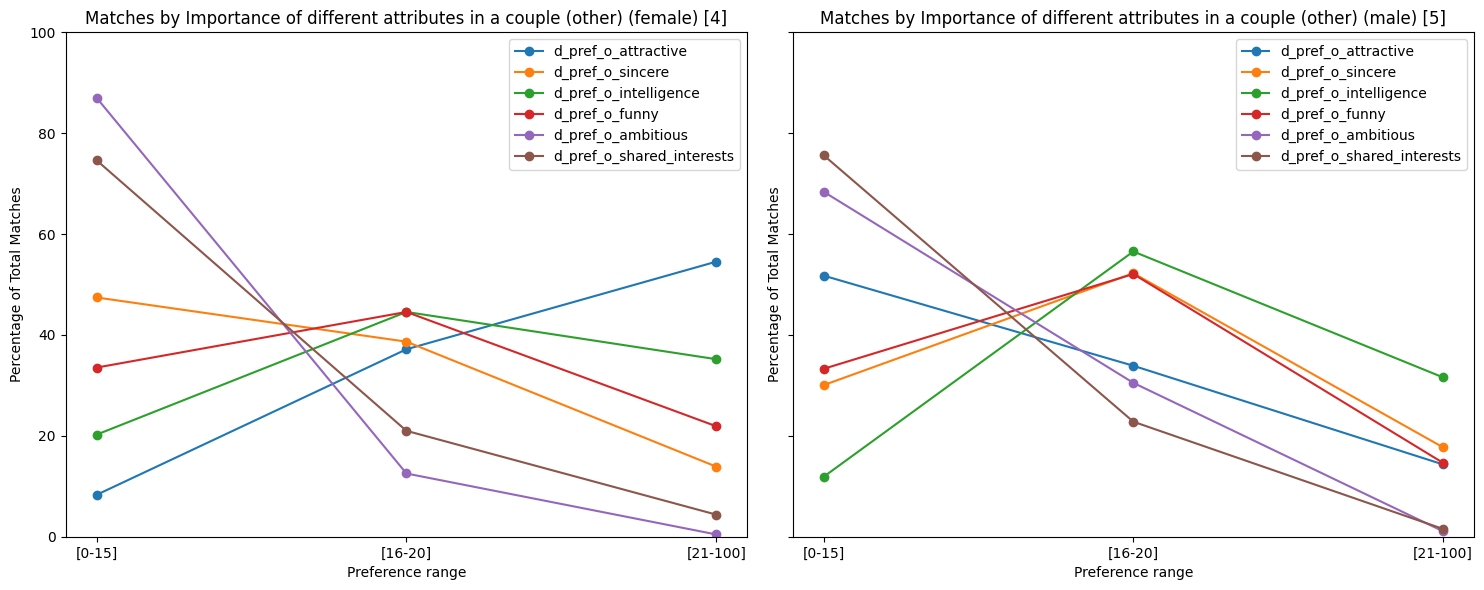

In [16]:
# Variables by group:

# Importance of different attributes in a couple (other): [0-15], [16-20], [21-100]
pref_importance_other = ['d_pref_o_attractive',
                         'd_pref_o_sincere',
                         'd_pref_o_intelligence', 
                         'd_pref_o_funny',
                         'd_pref_o_ambitious',
                         'd_pref_o_shared_interests']

# Rating of the other on the user: [0-5], [6-8], [9-10]
rate_other_me = ['d_attractive_o', 
                 'd_sinsere_o', 
                 'd_intelligence_o',  
                 'd_funny_o',
                 'd_ambitous_o',
                 'd_shared_interests_o']

# Importance of different attributes in a couple (user): [0-15], [16-20], [21-100]
pref_importance_me = ['d_attractive_important', 
                      'd_sincere_important', 
                      'd_intellicence_important',
                      'd_funny_important',
                      'd_ambtition_important', 
                      'd_shared_interests_important']

# Self-perception of the user: [0-5], [6-8], [9-10]
self_perception = ['d_attractive', 
                   'd_sincere',  
                   'd_intelligence', 
                   'd_funny',  
                   'd_ambition']

# Score of the user over the other: [0-5], [6-8], [9-10]
rate_me_other = ['d_attractive_partner', 
                 'd_sincere_partner', 
                 'd_intelligence_partner', 
                 'd_funny_partner', 
                 'd_ambition_partner',
                 'd_shared_interests_partner']

# User interests: [0-5], [6-8], [9-10]
interest = ['d_sports',
            'd_tvsports', 
            'd_exercise', 
            'd_dining', 
            'd_museums',
            'd_art',
            'd_hiking',
            'd_gaming', 
            'd_clubbing',
            'd_reading', 
            'd_tv', 
            'd_theater',
            'd_movies', 
            'd_concerts', 
            'd_music', 
            'd_shopping', 
            'd_yoga']

data_match = data[data['match'] == 1]
genders = data_match['gender'].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(genders), figsize=(15, 6), sharey=True)

for i, gender in enumerate(genders):
    ax = axes[i]
    filtered_data = data_match[data_match['gender'] == gender]

    total_matches = len(filtered_data)  # Total number of matches for the current gender

    for col in pref_importance_other:  # Iterate over all preference attributes
        counts = filtered_data[col].value_counts().sort_index()

        # Calculate relative frequencies
        relative_counts = counts / total_matches

        # Convert relative frequencies to percentages
        percentages = relative_counts * 100

        # Plot lines without stacking
        ax.plot(percentages.index, percentages, label=col, marker='o')

    ax.set_xlabel('Preference range')
    ax.set_ylabel('Percentage of Total Matches')
    ax.set_ylim(0, 100)
    PLOT_COUNT += 1
    ax.set_title(f'Matches by Importance of different attributes in a couple (other) ({gender}) [{PLOT_COUNT}]')
    ax.legend()

plt.tight_layout()
plt.show()

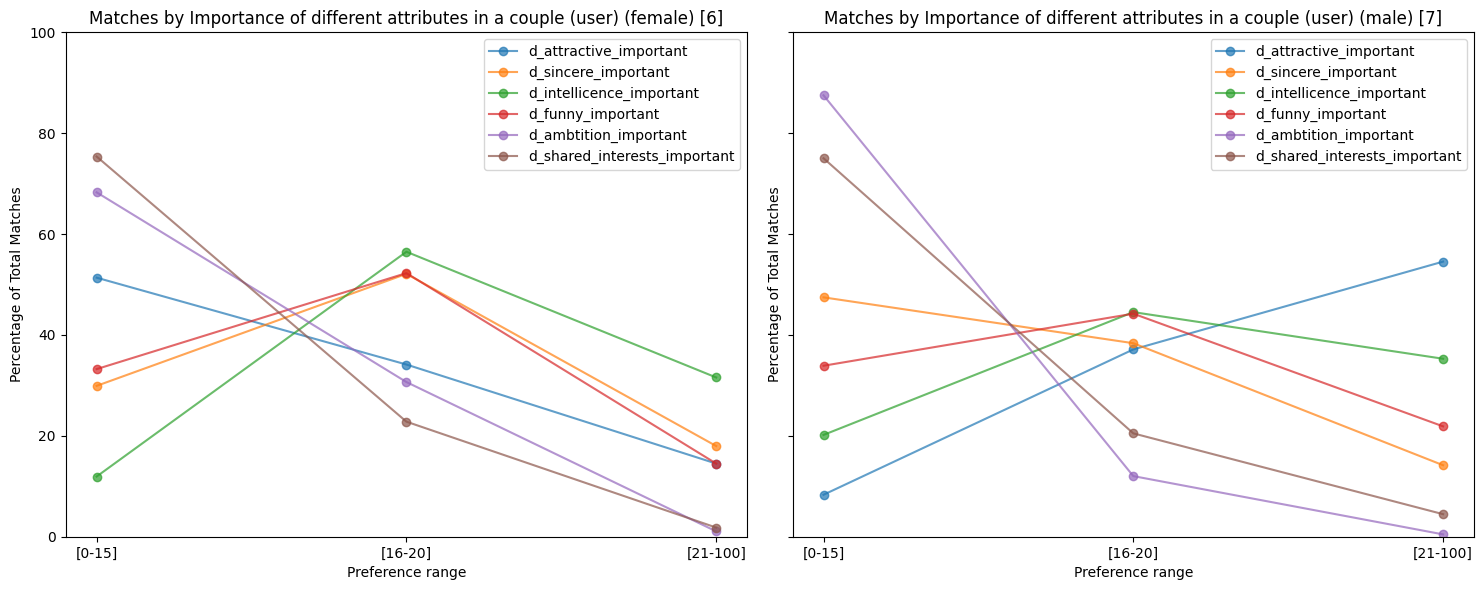

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=len(genders), figsize=(15, 6), sharey=True)

for i, gender in enumerate(genders):
    ax = axes[i]
    filtered_data = data_match[data_match['gender'] == gender]

    total_matches = len(filtered_data)

    for col in pref_importance_me:
        counts = filtered_data[col].value_counts().sort_index()

        relative_counts = counts / total_matches

        percentages = relative_counts * 100

        ax.plot(percentages.index, percentages, label=col, marker='o', alpha=0.7)

    ax.set_xlabel('Preference range')
    ax.set_ylabel('Percentage of Total Matches')
    ax.set_ylim(0, 100)
    PLOT_COUNT += 1
    ax.set_title(f'Matches by Importance of different attributes in a couple (user) ({gender}) [{PLOT_COUNT}]')
    ax.legend()

plt.tight_layout()
plt.show()

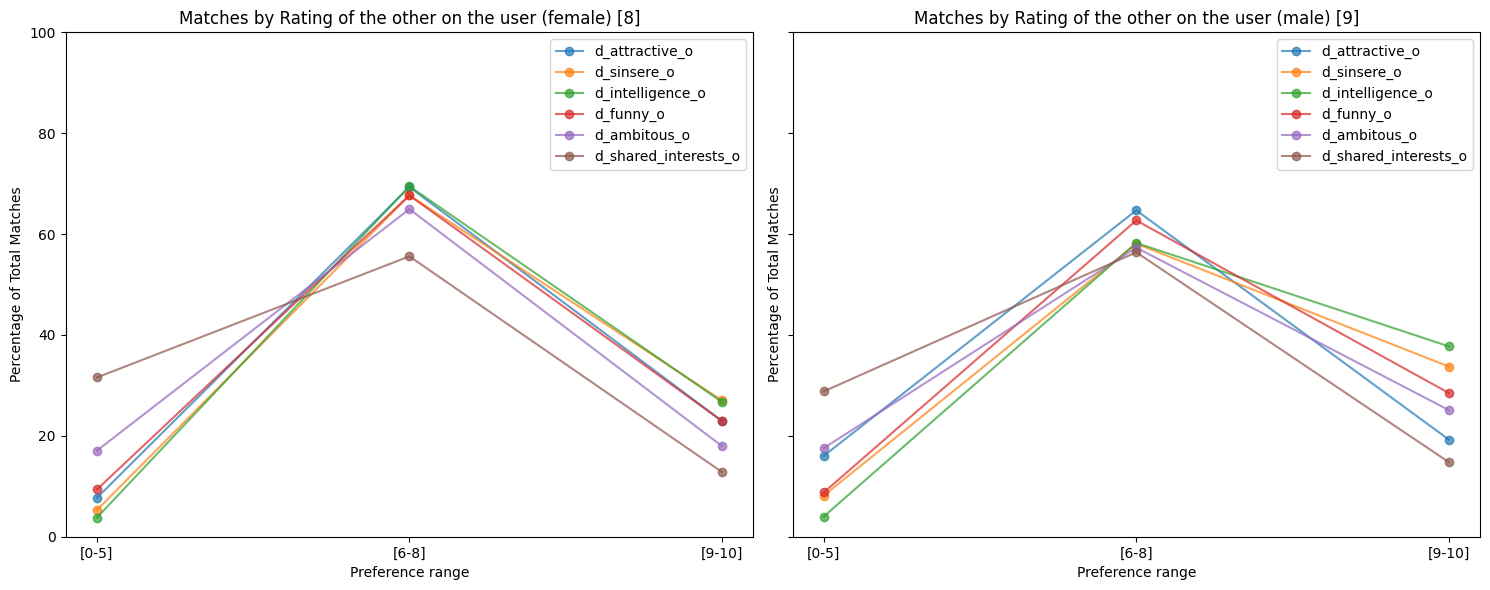

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=len(genders), figsize=(15, 6), sharey=True)

for i, gender in enumerate(genders):
    ax = axes[i]
    filtered_data = data_match[data_match['gender'] == gender]

    total_matches = len(filtered_data)

    for col in rate_other_me:
        counts = filtered_data[col].value_counts().sort_index()

        relative_counts = counts / total_matches

        percentages = relative_counts * 100

        ax.plot(percentages.index, percentages, label=col, marker='o', alpha=0.7)

    ax.set_xlabel('Preference range')
    ax.set_ylabel('Percentage of Total Matches')
    ax.set_ylim(0, 100)
    PLOT_COUNT += 1
    ax.set_title(f'Matches by Rating of the other on the user ({gender}) [{PLOT_COUNT}]')
    ax.legend()

plt.tight_layout()
plt.show()

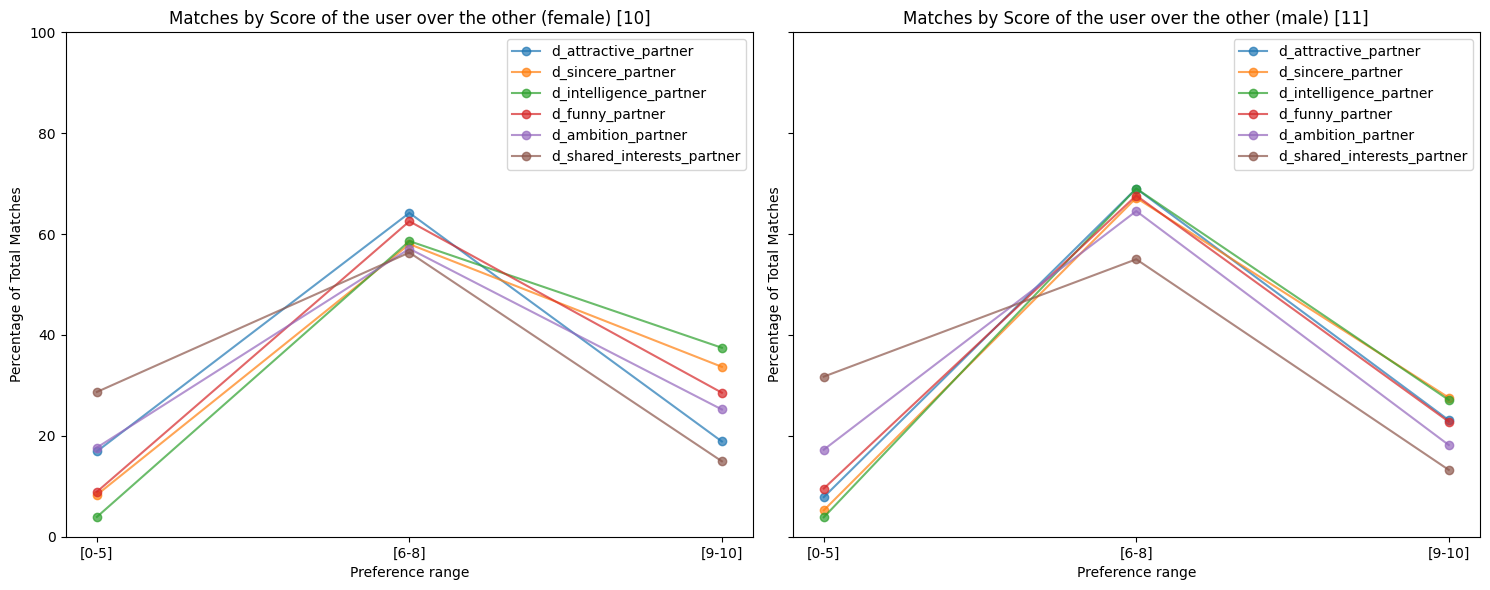

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=len(genders), figsize=(15, 6), sharey=True)

for i, gender in enumerate(genders):
    ax = axes[i]
    filtered_data = data_match[data_match['gender'] == gender]

    total_matches = len(filtered_data)

    for col in rate_me_other:
        counts = filtered_data[col].value_counts().sort_index()

        relative_counts = counts / total_matches

        percentages = relative_counts * 100

        ax.plot(percentages.index, percentages, label=col, marker='o', alpha=0.7)

    ax.set_xlabel('Preference range')
    ax.set_ylabel('Percentage of Total Matches')
    ax.set_ylim(0, 100)
    PLOT_COUNT += 1
    ax.set_title(f'Matches by Score of the user over the other ({gender}) [{PLOT_COUNT}]')
    ax.legend()

plt.tight_layout()
plt.show()

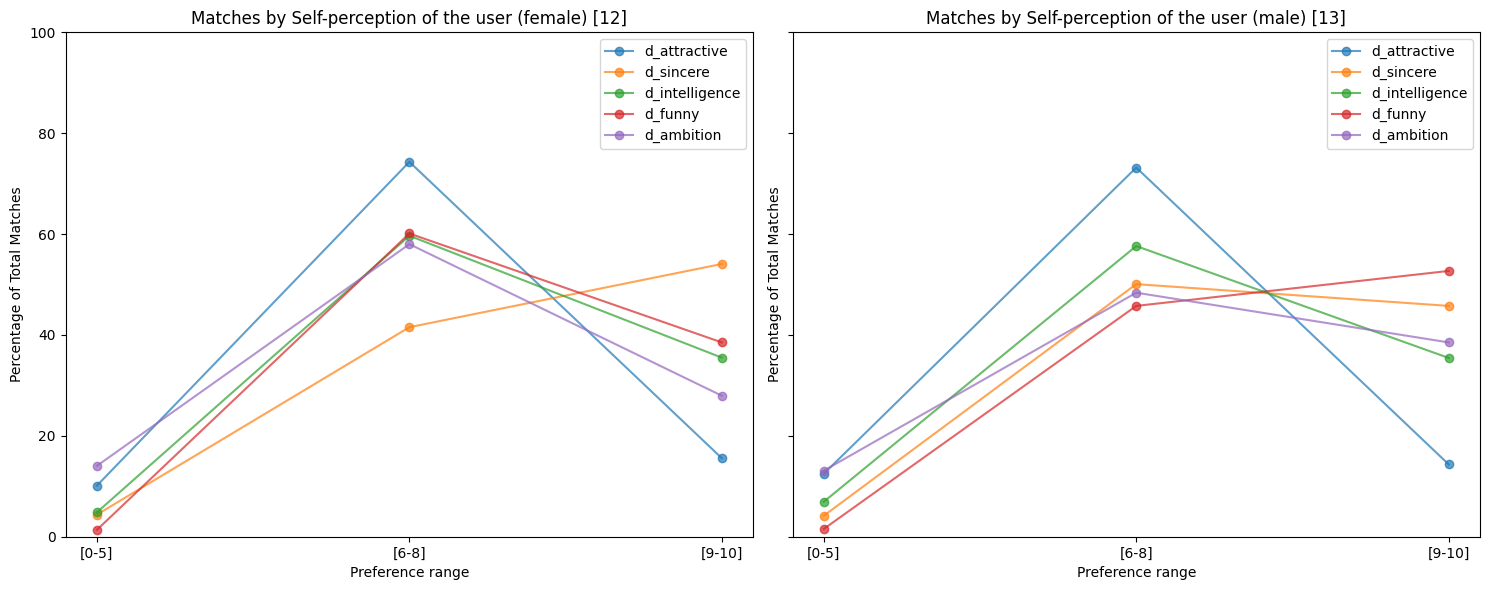

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=len(genders), figsize=(15, 6), sharey=True)

for i, gender in enumerate(genders):
    ax = axes[i]
    filtered_data = data_match[data_match['gender'] == gender]

    total_matches = len(filtered_data)

    for col in self_perception:
        counts = filtered_data[col].value_counts().sort_index()

        relative_counts = counts / total_matches

        percentages = relative_counts * 100

        ax.plot(percentages.index, percentages, label=col, marker='o', alpha=0.7)

    ax.set_xlabel('Preference range')
    ax.set_ylabel('Percentage of Total Matches')
    ax.set_ylim(0, 100)
    PLOT_COUNT += 1
    ax.set_title(f'Matches by Self-perception of the user ({gender}) [{PLOT_COUNT}]')
    ax.legend()

plt.tight_layout()
plt.show()

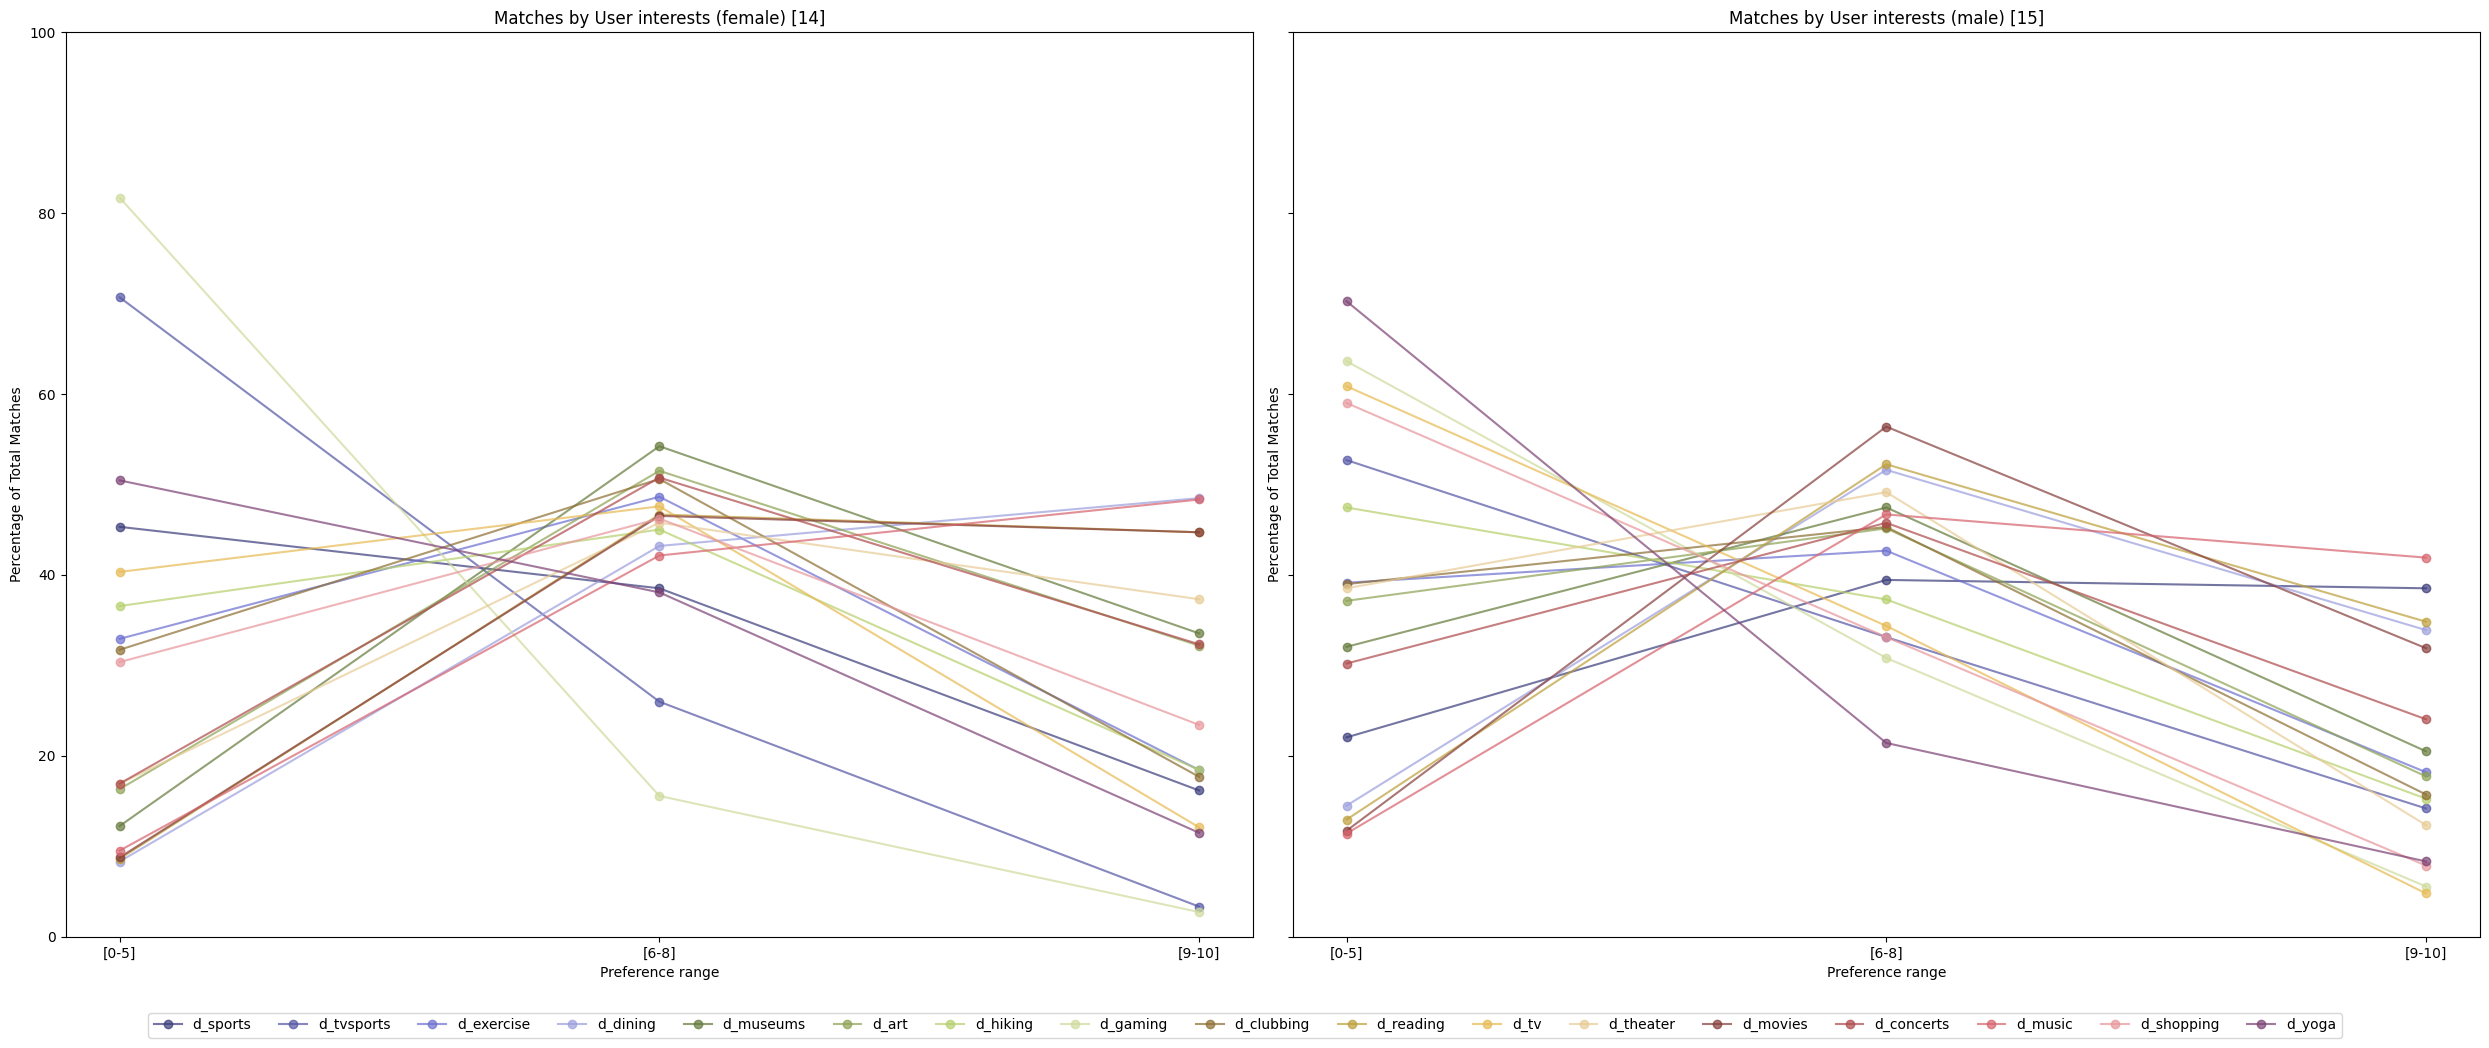

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=len(genders), figsize=(25, 10), sharey=True)

colors = plt.cm.tab20b.colors

legend_added = False

for i, gender in enumerate(genders):
    ax = axes[i]
    filtered_data = data_match[data_match['gender'] == gender]

    total_matches = len(filtered_data)

    for col, color in zip(interest, colors):
        counts = filtered_data[col].value_counts().sort_index()
        
        relative_counts = counts / total_matches

        percentages = relative_counts * 100

        ax.plot(percentages.index, percentages, label=col, marker='o', color=color, alpha=0.7)

    ax.set_xlabel('Preference range')
    ax.set_ylabel('Percentage of Total Matches')
    ax.set_ylim(0, 100)
    PLOT_COUNT += 1
    ax.set_title(f'Matches by User interests ({gender}) [{PLOT_COUNT}]')

# Add custom legend
if not legend_added:
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(interest))  # Show legend in 1 column per attribute
    legend_added = True

plt.tight_layout()
plt.show()

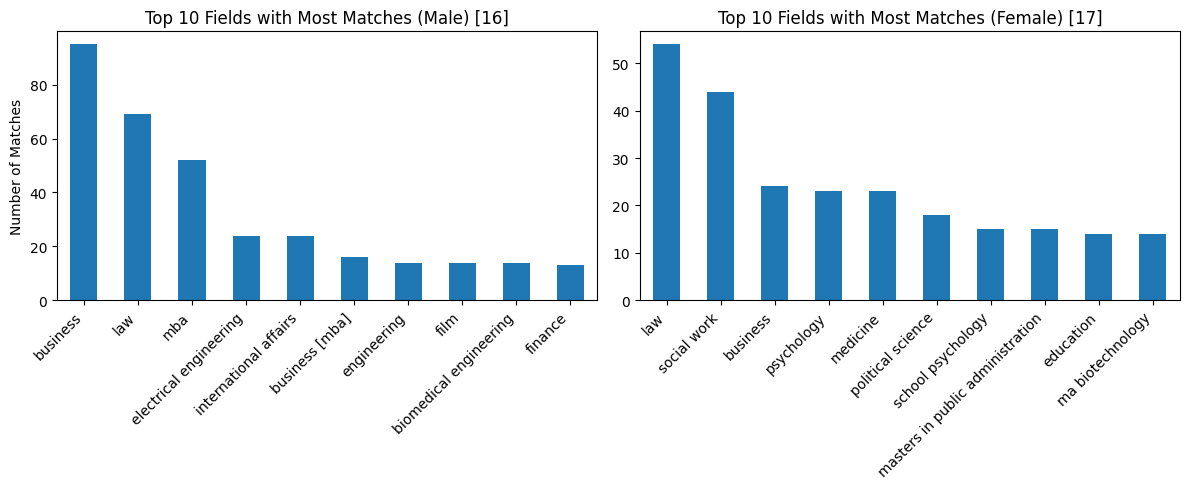

In [22]:
top_10_fields_male = data_match[data_match['gender'] == 'male']['field'].value_counts().nlargest(10)
top_10_fields_female = data_match[data_match['gender'] == 'female']['field'].value_counts().nlargest(10)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# 'male'
PLOT_COUNT += 1
ax_male = top_10_fields_male.plot(kind='bar', title=f'Top 10 Fields with Most Matches (Male) [{PLOT_COUNT}]', ax=axes[0])
ax_male.set_xlabel('')
ax_male.set_ylabel('Number of Matches')
ax_male.set_xticklabels(ax_male.get_xticklabels(), rotation=45, ha='right')

# 'female'
PLOT_COUNT += 1
ax_female = top_10_fields_female.plot(kind='bar', title=f'Top 10 Fields with Most Matches (Female) [{PLOT_COUNT}]', ax=axes[1])
ax_female.set_xlabel('')
ax_female.set_ylabel('')
ax_female.set_xticklabels(ax_female.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

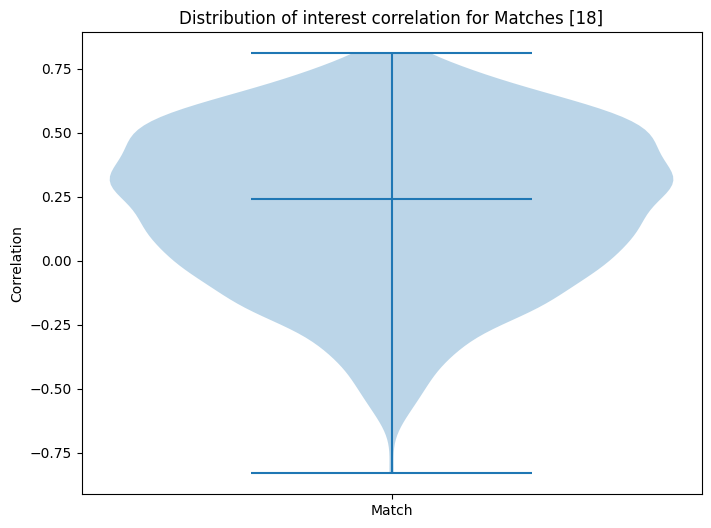

In [23]:
PLOT_COUNT += 1
plt.figure(figsize=(8, 6))
plt.violinplot([data_match['interests_correlate']], showmedians=True)
plt.xticks([1], ['Match'])
plt.title(f'Distribution of interest correlation for Matches [{PLOT_COUNT}]')
plt.ylabel('Correlation')
plt.show()

Let's summarize the findings from a visual exploration of the data. The graphs depict the number of matches for each discretization based on columns, measuring the success and importance of each category. Notably, variables reflecting the importance of couple attributes [4-7] are duplicated for both users, suggesting the pairing of the same individuals, resulting in the data being saved twice. This also happens with the data of the scores: [8-11]. Note that the labels may be counter-intuitive at first glance and that they can contradict each other (female [4] != female [6]), but that's because the data is saved twice so it appears as the perspective of one and the other. This is why we only have to focus on those data that refer to the user (since this approach is also consistent with the previous study of this data). 

To analyze the different graphs now, we will focus mainly on the trend described by the different proportions of each category. If we look at the data on the importance of attributes [6-7], we can see that for both sexes it is quite important that the partner is intelligent, as well as funny and sincere. Also for both sexes, it is seen that it is not important that the partner is ambitious or shares interests. Men stand out because they focus considerably more on the partner's attractiveness, while women focus on the man's intelligence, and value the partner's ambition more.

Regarding the other person's rating tables [8-9], it should be noted that most matches, for both sexes, rate the partner between 6 and 8, showing a conservative behavior when it comes to short dates . The main difference between both genders is that men tend to score higher than women. If the score above 5 is added, it can be seen that women focused more (positively) on the attributes of intelligence, sincerity and fun, as expected; while men scored more sincerity, intelligence and that they were fun. Interestingly, men value attractiveness more in a partner, but in the experiment they did not leave such high scores.

If we look at the self-perception graphs [12-13], we see that most matches, for both sexes, are rated between 6 and 8, but they differ from the ratings perceived by others that many tend to rate themselves above 8. The best matching data for both genders is that the funnier you were, as well as the more sincere you were, the better. The difference between the genders is that women who have more matches tend to consider themselves very honest; while men tend to consider themselves more ambitious and fun.

Next, if we look at the matches by interests [14-15], we see that there are many variables that could mean the same thing, which is why I will focus only on those people who are minimally interested in the category that appears represented [+5]. Interested in 6 to 8, women tend to get more matches if they are interested in sports, music, shopping and art. Men, on the other hand, are more successful if they are interested in sports, shopping, music and watching movies. As for those who are very interested in a subject, women are more successful when it is for dining, whatching movies or music. Men for sport and shopping.

In short, it means that the majority is more successful in the activities most common to the rest of the participants, that is to say, that their interests are linked.

Regarding the most successful jobs [16-17], there is a slight difference between men and women. Women tend to prefer men who work as entrepreneurs, lawyers, in marketing, engineering or finance. Men tend to prefer women who work as lawyers, social workers, entrepreneurs, psychologists, doctors, in politics or in public administration. In general, women tend to prefer less variety of specializations than men.

Finally, you can see in the graph [18] that the more interests the couples share, the more matches there are. Even if they dont consider it important.

### 2.1. Type correction:

In this code segment we are going to correct the typing of the data to transform them into numerical values that can be interpreted later by prediction algorithms.

We will save the results in SpeedDating_processed.csv for the intake of the other notebook.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7802 entries, 0 to 7801
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        7802 non-null   object 
 1   age                           7802 non-null   float64
 2   age_o                         7802 non-null   float64
 3   d_d_age                       7802 non-null   object 
 4   race                          7802 non-null   object 
 5   race_o                        7802 non-null   object 
 6   samerace                      7802 non-null   int64  
 7   d_importance_same_race        7802 non-null   object 
 8   d_importance_same_religion    7802 non-null   object 
 9   field                         7802 non-null   object 
 10  d_pref_o_attractive           7802 non-null   object 
 11  d_pref_o_sincere              7802 non-null   object 
 12  d_pref_o_intelligence         7802 non-null   object 
 13  d_p

In [25]:
# gender
data['gender'] = data['gender'].map({'female': 0, 'male': 1})

# d_d_age
data['d_d_age'] = data['d_d_age'].map({'[0-1]': 0, '[2-3]': 1, '[4-6]': 2, '[7-37]': 3})

# race
data['race'] = data['race'].map({'European/Caucasian-American': 0,
                                 'Latino/Hispanic American': 1,
                                 'Black/African American': 2,
                                 'Asian/Pacific Islander/Asian-American': 3,
                                 'Other': 4})

data['race_o'] = data["race_o"].map({'European/Caucasian-American': 0,
                                 'Latino/Hispanic American': 1,
                                 'Black/African American': 2,
                                 'Asian/Pacific Islander/Asian-American': 3,
                                 'Other': 4})

# d_importance_same_race
data['d_importance_same_race'] = data['d_importance_same_race'].map({'[0-1]': 0, '[2-5]': 1, '[6-10]': 2})

# d_importance_same_religion
data['d_importance_same_religion'] = data['d_importance_same_religion'].map({'[0-1]': 0, '[2-5]': 1, '[6-10]': 2})

# Field
field_dict = data["field"].value_counts().to_dict()

for i, (k, v) in enumerate(field_dict.items()):
    field_dict[k] = i

data['field'] = data['field'].map(field_dict)

# Importance of different attributes in a couple (other) (user)
val_dict = {'[0-15]': 0, '[16-20]': 1, '[21-100]': 2}

for col in pref_importance_other:
    data[col] = data[col].replace(val_dict)
    
for col in pref_importance_me:
    data[col] = data[col].replace(val_dict)

# Rating of the other on the user
# Score of the user over the other
# User interests
val_dict = {'[0-5]': 0, '[6-8]': 1, '[9-10]': 2}

for col in rate_other_me:
    data[col] = data[col].replace(val_dict)
    
for col in self_perception:
    data[col] = data[col].replace(val_dict)
    
for col in rate_me_other:
    data[col] = data[col].replace(val_dict)
    
for col in interest:
    data[col] = data[col].replace(val_dict)

In [26]:
print(f"Dataframe with {len(data.columns)} columns and {len(data.index)} rows\n")
print("Remaining NA:", data.isnull().sum().sum(), "\n")
data.info()

# Save final dataset:
data.to_csv("./Data/SpeedDating_processed.csv")

Dataframe with 58 columns and 7802 rows

Remaining NA: 0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7802 entries, 0 to 7801
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        7802 non-null   int64  
 1   age                           7802 non-null   float64
 2   age_o                         7802 non-null   float64
 3   d_d_age                       7802 non-null   int64  
 4   race                          7802 non-null   int64  
 5   race_o                        7802 non-null   int64  
 6   samerace                      7802 non-null   int64  
 7   d_importance_same_race        7802 non-null   int64  
 8   d_importance_same_religion    7802 non-null   int64  
 9   field                         7802 non-null   int64  
 10  d_pref_o_attractive           7802 non-null   int64  
 11  d_pref_o_sincere              7802 non-null   int64  
 12  d_p

In [27]:
if OPTIONAL_OUTPUTS == False:
    os.remove("./Data/SpeedDating_clean.csv")

### 2.2. Post-processed analysis

In this code segment we are going to expand the task of exploring the data through correlation matrices and analyzing the significance of the data in an example prediction model.

Remember that this segment can be disabled in the execution options at the beginning of the notebook.

In [28]:
if POST_PROCESSED_ANALYSIS == True:
    !pip install scikit-learn
    !pip install seaborn
    from sklearn.ensemble import RandomForestClassifier
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

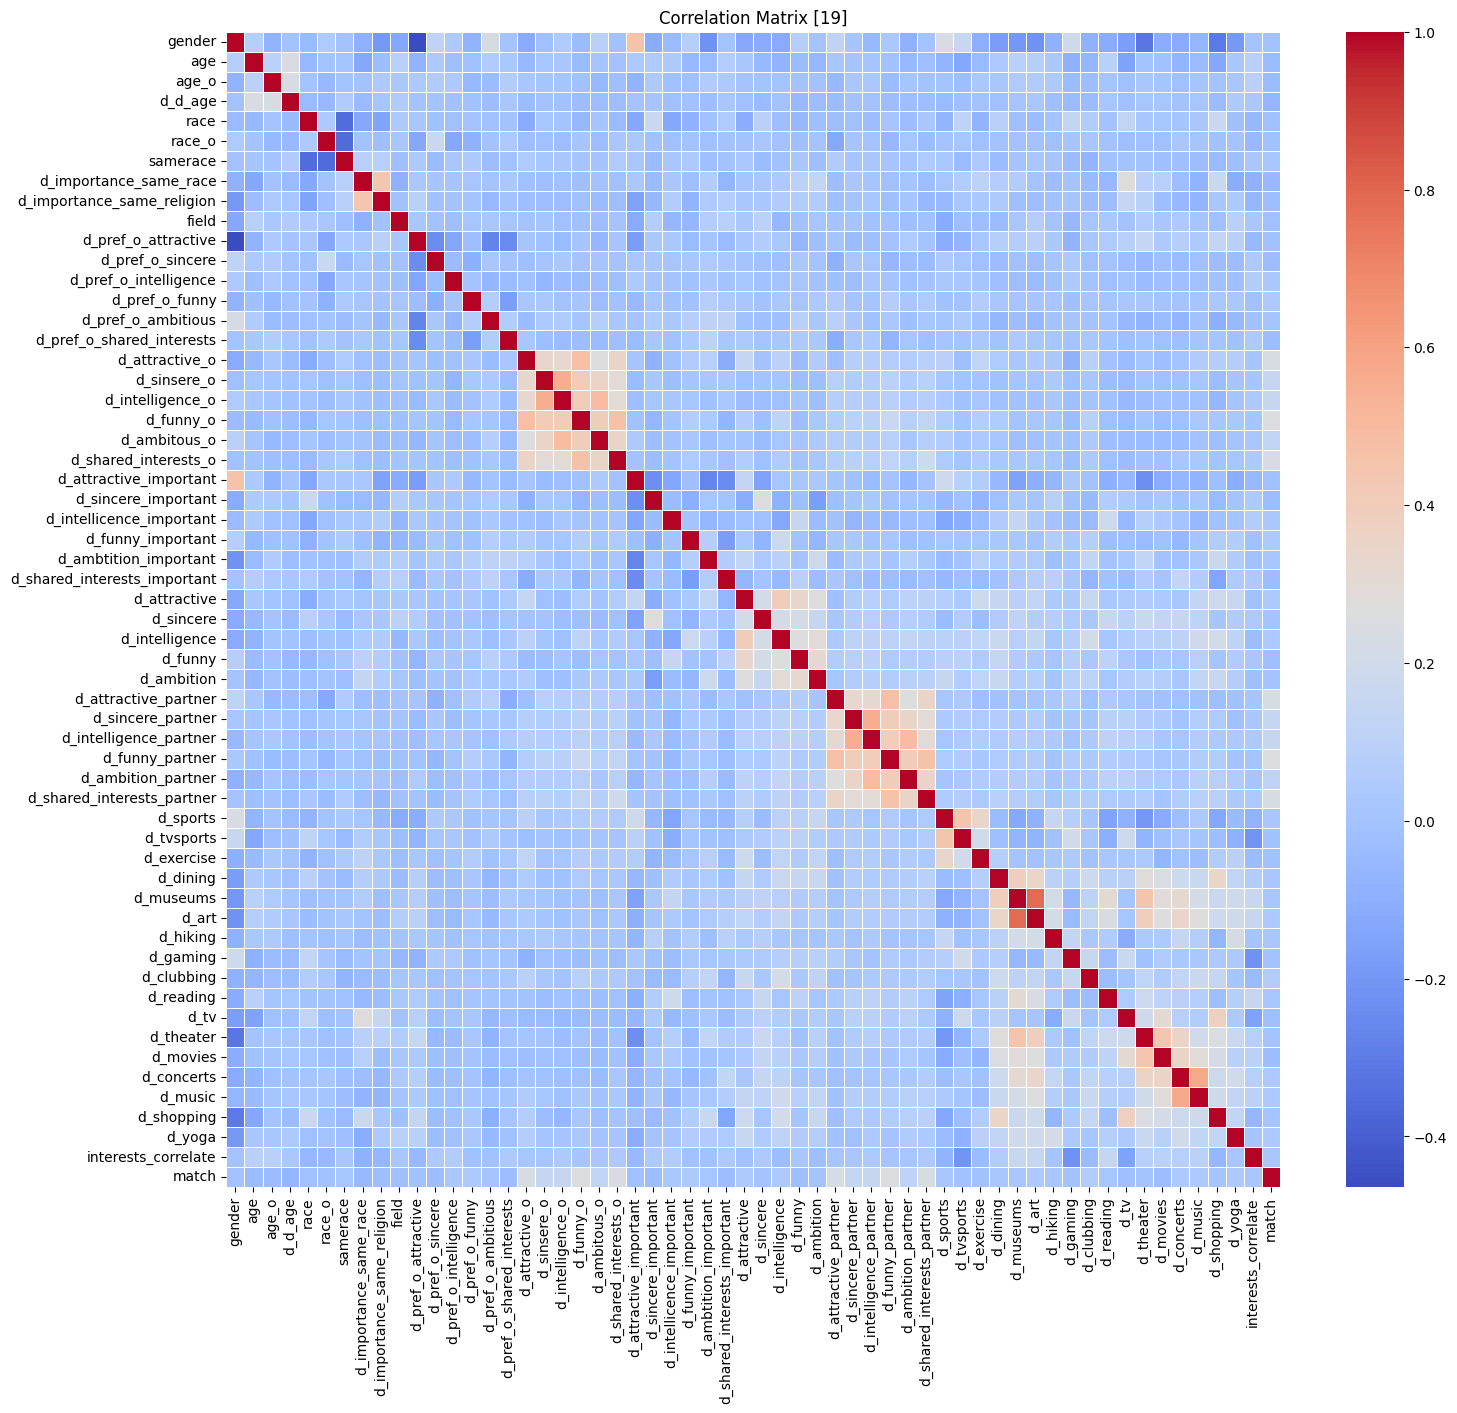

In [29]:
if POST_PROCESSED_ANALYSIS == True:
    PLOT_COUNT += 1
    correlation_matrix = data.corr()
    plt.figure(figsize=(17, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Matrix [{PLOT_COUNT}]')
    plt.show()

In the overall correlation matrix we can easily spot the different opinion blocks described above in the above code, as they stand out as squares that are correlated with each other.

It also highlights that scores on specific characteristics, d_attractive_o for example, are highly correlated with each other. It can be assumed that people tend to rate a person similarly in terms of characteristics based on what they can observe.

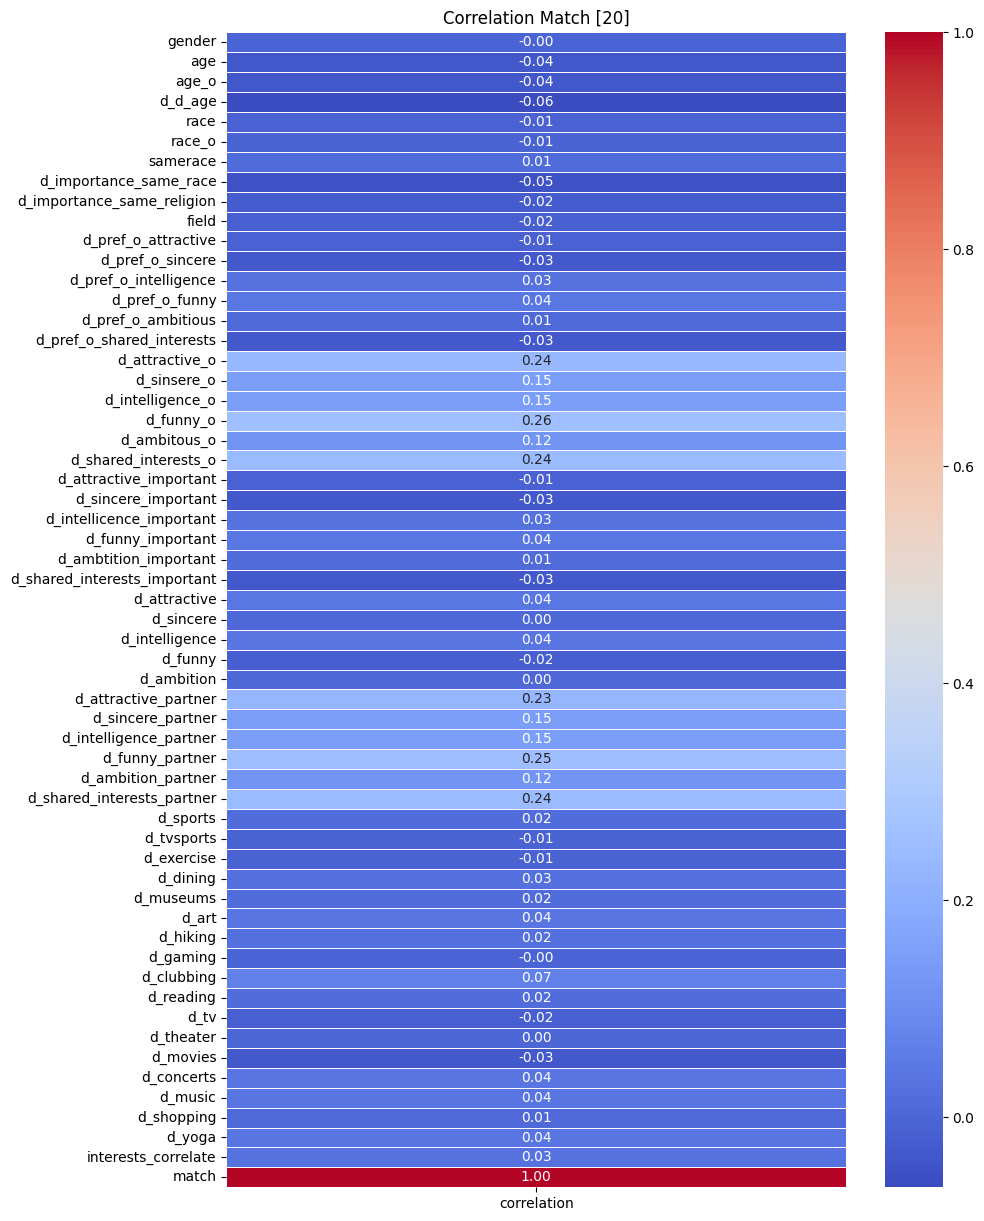

In [30]:
if POST_PROCESSED_ANALYSIS == True:
    PLOT_COUNT += 1
    correlation_matrix = data.corrwith(data['match'])
    correlation_matrix = pd.DataFrame(correlation_matrix, columns=['correlation'])
    plt.figure(figsize=(10, 15))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Match [{PLOT_COUNT}]')
    plt.show()

This correlation column shows how they correlate with the Match variable, it shows that the most correlated are the scores of one and the other, since it is assumed that the more correlation, the more interest you have in the person.

This leaves us with an apparent problem, since if we want to create an application with a predictive model, it cannot use scores, because they are not known to each other.

Now we will try to do a significance analysis of the data, with an unmodified dataset.

In [31]:
if POST_PROCESSED_ANALYSIS == True:
    X, y = data.drop('match', axis=1), data['match']
    
    # test / train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Train the model
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Get feature importance
    sig = clf.feature_importances_

    # Add names
    sig_dict = dict(zip(X.columns, sig))

    # Oder
    sig_dict_ordered = dict(sorted(sig_dict.items(),
                                   key=lambda x: x[1],
                                   reverse=True))
    
    # Print
    for i, (k, v) in enumerate(sig_dict_ordered.items()):
        print(f"{k}: {round(v,3)}")

C:\Users\afran\.conda\envs\TFM\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\afran\.conda\envs\TFM\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


d_funny_o: 0.045
age_o: 0.043
interests_correlate: 0.041
field: 0.038
d_attractive_partner: 0.035
d_pref_o_sincere: 0.035
age: 0.033
d_d_age: 0.033
d_attractive_o: 0.033
d_funny_partner: 0.032
d_pref_o_attractive: 0.027
d_pref_o_shared_interests: 0.023
d_pref_o_intelligence: 0.022
race_o: 0.021
d_importance_same_race: 0.019
d_pref_o_funny: 0.018
d_shared_interests_o: 0.017
d_shared_interests_partner: 0.017
d_attractive_important: 0.016
d_exercise: 0.015
d_pref_o_ambitious: 0.015
race: 0.015
d_sincere_important: 0.015
d_reading: 0.014
d_importance_same_religion: 0.014
d_ambitous_o: 0.014
samerace: 0.014
d_sinsere_o: 0.013
d_intelligence_o: 0.013
d_funny: 0.013
d_shared_interests_important: 0.013
d_shopping: 0.013
d_movies: 0.013
d_sports: 0.013
d_theater: 0.012
d_funny_important: 0.012
d_ambition: 0.012
d_intellicence_important: 0.012
d_tv: 0.012
d_clubbing: 0.011
d_hiking: 0.011
d_concerts: 0.011
d_ambition_partner: 0.011
d_sincere_partner: 0.011
d_music: 0.011
d_dining: 0.011
d_museum

As far as we can see, after several runs, the most important variables are scores (as expected), age, interests that correlate, field of work, and preferences in an ideal match.

It is particularly interesting that correlated interests are so relevant, because most interests by themselves do not add much to the model. Also, a good approximation for a possible application would be to calculate whether interests are correlated, not to take tastes per se. So it is plausible to be able to remove all individual tastes and be left alone with the value of whether they are correlated or not.

As we mentioned above, our hypothetical application would also have the problem of not being able to have scores. The best decision will be to train the model without these parameters, as it is not realistic in a business context.

Now I will show how the significance of the variables would be for the proposed set:

In [32]:
if POST_PROCESSED_ANALYSIS == True:
    data = data.drop(interest, axis=1)
    data = data.drop(rate_other_me, axis=1)
    data = data.drop(rate_me_other, axis=1)
    
    X, y = data.drop('match', axis=1), data['match']
    
    # test / train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Train the model
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Get feature importance
    sig = clf.feature_importances_

    # Add names
    sig_dict = dict(zip(X.columns, sig))

    # Oder
    sig_dict_ordered = dict(sorted(sig_dict.items(),
                                   key=lambda x: x[1],
                                   reverse=True))
    
    # Print
    for i, (k, v) in enumerate(sig_dict_ordered.items()):
        print(f"{k}: {round(v,3)}")

interests_correlate: 0.087
age_o: 0.085
field: 0.072
age: 0.065
d_pref_o_sincere: 0.054
d_d_age: 0.051
d_pref_o_attractive: 0.047
d_pref_o_shared_interests: 0.038
race_o: 0.036
d_pref_o_intelligence: 0.036
d_pref_o_funny: 0.034
d_importance_same_race: 0.032
d_sincere_important: 0.031
race: 0.031
d_attractive_important: 0.03
d_importance_same_religion: 0.027
d_shared_interests_important: 0.025
d_funny_important: 0.024
d_intellicence_important: 0.024
d_funny: 0.022
d_ambition: 0.022
d_pref_o_ambitious: 0.021
d_sincere: 0.02
d_intelligence: 0.02
samerace: 0.018
d_attractive: 0.017
gender: 0.016
d_ambtition_important: 0.014


No big changes are detected in the significance variables, now I will try to test this model to finish it

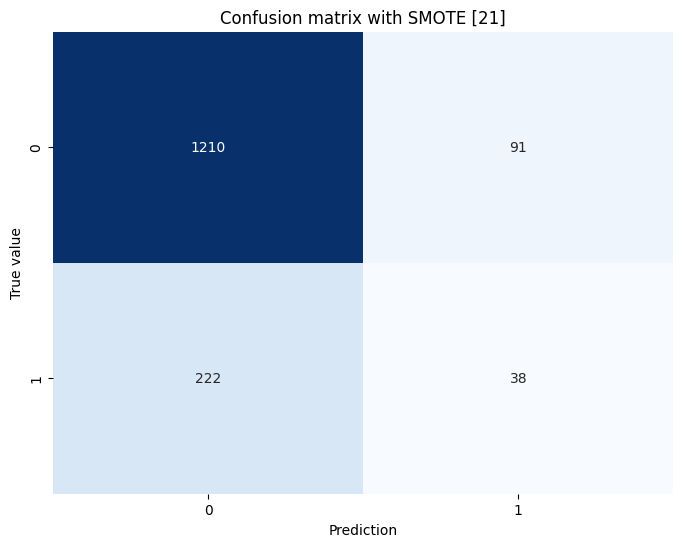

In [33]:
if POST_PROCESSED_ANALYSIS == True:
    X, y = data.drop('match', axis=1), data['match']
    
    # test / train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Train model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Make prediction
    y_pred = rf_model.predict(X_test)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot
    PLOT_COUNT += 1
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion matrix with SMOTE [{PLOT_COUNT}]")
    plt.xlabel("Prediction")
    plt.ylabel("True value")
    plt.show()

Finally, as can be seen in the confusion matrix, the number of false negatives in this model stands out, as well as the low number of true positives. We can conclude that it is not quite a good model. A more thorough search will be required to find the correct model.